In [ ]:
import csv
import codecs
import argparse
import os
from pathlib import Path
import pandas as pd
import sys, argparse
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import gc
from spacy.lang.en import English
import re
import string
from tqdm import tqdm
import numpy as np
from scipy.sparse import coo_matrix, vstack
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter
from bs4 import BeautifulSoup

In [ ]:
path = '/content/drive/MyDrive/DATA641 Final Project/nlp_project_data/umd_reddit_suicidewatch_dataset_v2/'

# **Functions**

In [ ]:
def normalize_tokens(tokenlist):
    normalized_tokens = [token.lower().replace('_','+') for token in tokenlist   # lowercase, _ => +
                             if re.search('[^\s]', token) is not None            # ignore whitespace tokens
                             and not token.startswith("@")                       # ignore  handles
                        ]
    return normalized_tokens    

def ngrams(tokens, n):
    return [tokens[i:i+n] for i in range(len(tokens)-n+1)]

def filter_punctuation_bigrams(ngrams):
    punct = string.punctuation
    return [ngram   for ngram in ngrams   if ngram[0] not in punct and ngram[1] not in punct]

def filter_stopword_bigrams(ngrams, stopwords):
    result = [ngram   for ngram in ngrams   if ngram[0] not in stopwords and ngram[1] not in stopwords]
    return result

In [ ]:
def convert_text_into_features(X, stopwords_arg, analyzefn="word", range=(1,1)):
    training_vectorizer = CountVectorizer(stop_words=stopwords_arg,
                                          analyzer=analyzefn,
                                          lowercase=True,
                                          ngram_range=range)
    X_features = training_vectorizer.fit_transform(X)
    return X_features, training_vectorizer

def convert_lines_to_feature_strings(lines, stopwords, remove_stopword_bigrams=True):

    print(" Converting from raw text to unigram and bigram features")
    if remove_stopword_bigrams:
        print(" Includes filtering stopword bigrams")
        
    print(" Initializing")
    nlp          = English(parser=False)
    all_features = []
    print(" Iterating through documents extracting unigram and bigram features")
    for line in tqdm(lines):
        
        # Get spacy tokenization and normalize the tokens
        spacy_analysis    = nlp(line)
        spacy_tokens      = [token.orth_ for token in spacy_analysis]
        normalized_tokens = normalize_tokens(spacy_tokens)

        # Collect string bigram tokens as features
        bigrams = []
        bigram_tokens     = ["_".join(bigram) for bigram in bigrams]
        bigrams           = ngrams(normalized_tokens, 2) 
        bigrams           = filter_punctuation_bigrams(bigrams)
        if remove_stopword_bigrams:
            bigrams = filter_stopword_bigrams(bigrams, stopwords)
        bigram_tokens = ["_".join(bigram) for bigram in bigrams]

        # Conjoin the feature lists and turn into a space-separated string of features.
        # E.g. if unigrams is ['coffee', 'cup'] and bigrams is ['coffee_cup', 'white_house']
        # then feature_string should be 'coffee cup coffee_cup white_house'

        bigram_tokens = " ".join(bigram_tokens)
        feature_string = bigram_tokens 

        # Add this feature string to the output
        all_features.append(feature_string)


    print(" Feature string for first document: '{}'".format(all_features[0]))
        
    return all_features

def most_informative_features(vectorizer, classifier, n=20):
    # Adapted from https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers#11116960
    feature_names       = vectorizer.get_feature_names()
    coefs_with_features = sorted(zip(classifier.coef_[0], feature_names))
    top                 = zip(coefs_with_features[:n], coefs_with_features[:-(n + 1):-1])
    for (coef_1, feature_1), (coef_2, feature_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, feature_1, coef_2, feature_2))

In [ ]:
def load_stopwords(filename):
    stopwords = []
    with codecs.open(filename, 'r', encoding='ascii', errors='ignore') as fp:
        stopwords = fp.read().split('\n')
    return set(stopwords)

stopwords = load_stopwords(path+'mallet_en_stoplist.txt')   

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]/,.!?]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

# **Loading Data**

In [ ]:
crowd_train = pd.read_csv(path+'crowd/train/crowd_train.csv')
task_A_train = pd.read_csv(path+'crowd/train/task_A_train.posts.csv')
task_B_train = pd.read_csv(path+'crowd/train/task_B_train.posts.csv')
task_C_train = pd.read_csv(path+'crowd/train/task_B_train.posts.csv')
shared_task_train = pd.read_csv(path+'crowd/train/shared_task_posts.csv')

In [ ]:
crowd_test = pd.read_csv(path+'crowd/test/crowd_test.csv')
task_A_test = pd.read_csv(path+'crowd/test/task_A_test.posts.csv')
task_B_test = pd.read_csv(path+'crowd/test/task_B_test.posts.csv')
task_C_test = pd.read_csv(path+'crowd/test/task_B_test.posts.csv')
shared_task_test = pd.read_csv(path+'crowd/test/shared_task_posts_test.csv')

In [ ]:
label = np.array(['a','b','c','d'])
c = np.array(['Negative','Negative','Negative','Positive'])

d = np.vstack([label,c])

df_class = pd.DataFrame(data=d.T,columns=['label','class'])

df_class

,label,class
0,a,Negative
1,b,Negative
2,c,Negative
3,d,Positive


# **Task - only Suicide Watch**

In [ ]:
df_A_train = shared_task_train[shared_task_train['subreddit'] == 'SuicideWatch']
df_A_train = df_A_train.dropna()

In [ ]:
df_A_train = pd.merge(df_A_train,crowd_train,on='user_id')

df_A_train = pd.merge(df_A_train,df_class,on='label')

In [ ]:
df_A_test = shared_task_test[shared_task_test['subreddit'] == 'SuicideWatch']
df_A_test = df_A_test.dropna()

df_A_test = pd.merge(df_A_test,crowd_test,on='user_id')

df_A_test['label'] = df_A_test['raw_label']

df_A_test = pd.merge(df_A_test,df_class,on='label')

In [ ]:
X_train = convert_lines_to_feature_strings(df_A_train['post_body'],stopwords)

 Converting from raw text to unigram and bigram features
 Includes filtering stopword bigrams
 Initializing


  0%|          | 3/847 [00:00<00:34, 24.25it/s]

 Iterating through documents extracting unigram and bigram features


100%|██████████| 847/847 [00:27<00:00, 30.92it/s]

 Feature string for first document: 'fun_... smoke_... n't_remember fucking_hurt hurt_'s pain_inside okey_.. .._people cool_person fucking_wrong real_... head_... depression_... real_... male_... 80_...'


In [ ]:
X_train, training_vectorizer = convert_text_into_features(X_train,stopwords)

In [ ]:
X_test = convert_lines_to_feature_strings(df_A_test['post_body'],stopwords)
X_test = training_vectorizer.transform(X_test)

 Converting from raw text to unigram and bigram features
 Includes filtering stopword bigrams
 Initializing


  2%|▏         | 3/181 [00:00<00:06, 25.61it/s]

 Iterating through documents extracting unigram and bigram features


100%|██████████| 181/181 [00:06<00:00, 29.28it/s]

 Feature string for first document: 'stay_alive'


In [ ]:
data_A = pd.concat([df_A_train,df_A_test],axis=0)

In [ ]:
x = convert_lines_to_feature_strings(data_A['post_body'],stopwords)

 Converting from raw text to unigram and bigram features
 Includes filtering stopword bigrams
 Initializing


  0%|          | 3/1028 [00:00<00:34, 29.67it/s]

 Iterating through documents extracting unigram and bigram features


100%|██████████| 1028/1028 [00:35<00:00, 29.19it/s]

 Feature string for first document: 'fun_... smoke_... n't_remember fucking_hurt hurt_'s pain_inside okey_.. .._people cool_person fucking_wrong real_... head_... depression_... real_... male_... 80_...'


### **Logistic Regression**

In [ ]:
lr_classifier = LogisticRegression(solver='liblinear')
lr_classifier.fit(X_train, df_A_train['class'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
most_informative_features(training_vectorizer,lr_classifier,20)

	-1.0648	close_friends  		1.2100	gon_na         
	-0.9126	t_live         		0.7642	m_ready        
	-0.9117	feel_free      		0.7090	pain_          
	-0.7939	contemplating_suicide		0.6835	pain_anymore   
	-0.7704	wo_nt          		0.6154	ca_nt          
	-0.6846	ve_read        		0.6085	fall_asleep    
	-0.6153	financial_state		0.6032	m_schizophrenic
	-0.6148	t_remember     		0.5881	m_tired        
	-0.6082	m_sad          		0.5815	s_hard         
	-0.6061	t_trust        		0.5649	m_thinking     
	-0.5964	make_sense     		0.5564	long_time      
	-0.5956	dying_column   		0.5384	t_talk         
	-0.5792	m_shaking      		0.5099	mentally_ill   
	-0.5773	kinda_making   		0.5095	m_supposed     
	-0.5592	t_imagine      		0.5069	life_worse     
	-0.5465	2_hours        		0.5037	pretty_good    
	-0.5431	panic_attacks  		0.5006	single_day     
	-0.5342	feel_depressed 		0.4975	ve_decided     
	-0.5307	suicidal_thoughts		0.4800	carbon_monoxide
	-0.5286	horrible_thoughts		0.4626	20_years       


In [ ]:
lr_classifier.score(X_test,df_A_test['class'])

0.5359116022099447

In [ ]:
X_features,_ = convert_text_into_features(x,stopwords)

In [ ]:
accuracy_scores = cross_val_score(lr_classifier, X_features, 
                                  data_A['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores, np.mean(accuracy_scores), np.std(accuracy_scores)))

accuracy scores = [0.56851312 0.59475219 0.55847953], mean = 0.5739149460953973, stdev = 0.015292943087483109


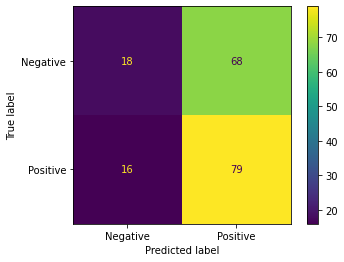

In [ ]:
metrics.plot_confusion_matrix(lr_classifier,X_test,df_A_test['class'])

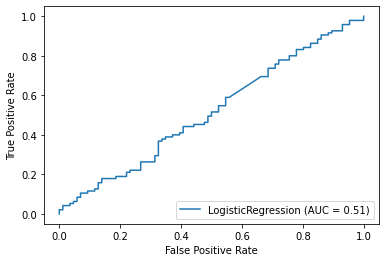

In [ ]:
metrics.plot_roc_curve(lr_classifier, X_test, df_A_test['class'])

### **Decision Trees**

In [ ]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train,df_A_train['class'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
tree.score(X_test,df_A_test['class'])

0.5524861878453039

In [ ]:
accuracy_scores = cross_val_score(tree, X_features, 
                                  data_A['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores, np.mean(accuracy_scores), np.std(accuracy_scores)))

accuracy scores = [0.53061224 0.58600583 0.53216374], mean = 0.5495939394972692, stdev = 0.02575488514437499


# **Task - everything**

In [ ]:
df_B_train = shared_task_train
df_B_train = df_B_train.dropna()
df_B_train = pd.merge(df_B_train,crowd_train,on='user_id')
df_B_train = pd.merge(df_B_train,df_class, on = 'label')

In [ ]:
df_B_test = shared_task_test
df_B_test = df_B_test.dropna()
df_B_test = pd.merge(df_B_test,crowd_test,on='user_id')
df_B_test['label'] = df_B_test['raw_label']
df_B_test = pd.merge(df_B_test,df_class, on = 'label')

In [ ]:
x_b = convert_lines_to_feature_strings(df_B_train['post_body'],stopwords)

 Converting from raw text to unigram and bigram features
 Includes filtering stopword bigrams
 Initializing
 Iterating through documents extracting unigram and bigram features


100%|██████████| 16600/16600 [09:01<00:00, 30.63it/s]

 Feature string for first document: 'time_ago seduce_beatiful beatiful_womens pass_exams real_motivation motivation_dosen't 3_years famous_people people_monument real_motivation life_motivation fucking_soul cry_beacuse nuklear_bomb create_road time_... soo_fat „_wanted wanted_” run_... 6_months 5_minutes days_ago make_test 20_minutes minutes_... 30_minutes minutes_... 40_minutes 60_minutes awesome_place'


In [ ]:
X_train_b, training_vectorizer_b = convert_text_into_features(x_b,stopwords)

In [ ]:
X_test_b =  convert_lines_to_feature_strings(df_B_test['post_body'],stopwords)
X_test_b_features = training_vectorizer_b.transform(X_test_b)

 Converting from raw text to unigram and bigram features
 Includes filtering stopword bigrams
 Initializing


  0%|          | 3/4906 [00:00<02:49, 28.88it/s]

 Iterating through documents extracting unigram and bigram features


100%|██████████| 4906/4906 [02:43<00:00, 30.07it/s]


 Feature string for first document: 'stay_alive'


### **Logistic Regression**

In [ ]:
lr_classifier_b = LogisticRegression(solver='liblinear')
lr_classifier_b.fit(X_train_b, df_B_train['class'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
most_informative_features(training_vectorizer_b,lr_classifier_b,20)

	-1.3879	m_running      		1.5380	wondering_thought
	-1.3478	itz_salust     		1.3662	post_deets     
	-1.1620	boarding_school		1.2632	hearing_voices 
	-1.1524	hey_fittit     		1.2234	hearing_loss   
	-1.1366	san_diego      		1.2185	asperger_      
	-1.1315	message_soccerstud2691		1.2166	m_17           
	-1.1119	agent_phantom  		1.1905	m_schizophrenic
	-1.1050	older_cousin   		1.1083	pain_          
	-1.0712	bike_shop      		1.0872	post_psn       
	-1.0596	grad_school    		1.0691	psn_bow        
	-1.0518	front_page     		1.0402	time_streams   
	-1.0506	rock_climbing  		1.0394	s_syndrome     
	-1.0438	m_finding      		1.0365	autistic_spectrum
	-1.0259	5_times        		1.0156	friend_code    
	-1.0138	t_decide       		0.9969	attempted_suicide
	-1.0066	close_friends  		0.9896	head_back      
	-0.9694	hey_           		0.9810	hearing_difficulties
	-0.9639	husband_       		0.9793	m_playing      
	-0.9367	reddit_alien   		0.9691	crota_         
	-0.9284	shit_          		0.9586	site_          


In [ ]:
lr_classifier_b.score(X_test_b_features,df_B_test['class'])

0.5521810028536486

In [ ]:
x_features_b = vstack([X_train_b,X_test_b_features])
data_B = pd.concat([df_B_train,df_B_test],axis=0)

In [ ]:
accuracy_scores_b = cross_val_score(lr_classifier_b, x_features_b, data_B['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores_b, 
                                                           np.mean(accuracy_scores_b), 
                                                           np.std(accuracy_scores_b)))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


accuracy scores = [0.55712094 0.53605803 0.54338728], mean = 0.5455220805912858, stdev = 0.008730390684411136


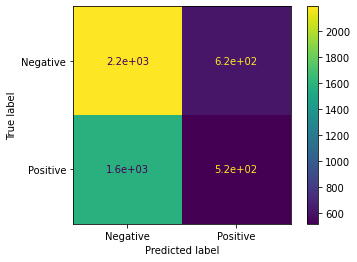

In [ ]:
metrics.plot_confusion_matrix(lr_classifier_b,X_test_b_features,df_B_test['class'])

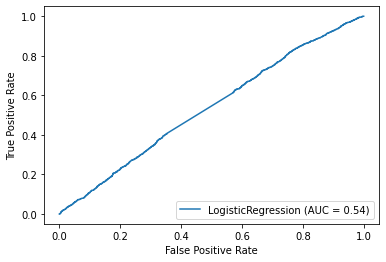

In [ ]:
metrics.plot_roc_curve(lr_classifier_b, X_test_b_features,df_B_test['class'])

### **Decision Trees**

In [ ]:
tree_b = DecisionTreeClassifier(criterion='entropy')
tree_b.fit(X_train_b, df_B_train['class'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
tree_b.score(X_test_b_features,df_B_test['class'])

0.5511618426416632

In [ ]:
accuracy_scores = cross_val_score(tree_b, x_features_b, data_B['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores_b, 
                                                           np.mean(accuracy_scores_b), 
                                                           np.std(accuracy_scores_b)))

accuracy scores = [0.55712094 0.53605803 0.54338728], mean = 0.5455220805912858, stdev = 0.008730390684411136


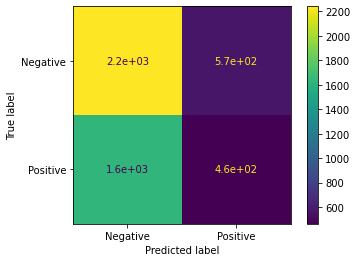

In [ ]:
metrics.plot_confusion_matrix(tree_b,X_test_b_features,df_B_test['class'])

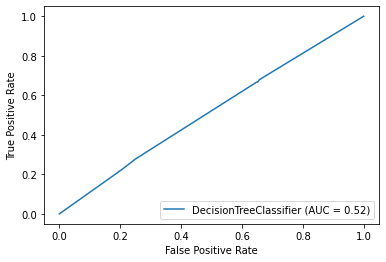

In [ ]:
metrics.plot_roc_curve(tree_b, X_test_b_features,df_B_test['class'])